In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import time
from matplotlib import pyplot as plt
import gym
import random
import mujoco_py

%load_ext autoreload
%autoreload 2

def set_seed(seed_number):
    os.environ['PYTHONHASHSEED']=str(seed_number)
    random.seed(seed_number)
    np.random.seed(seed_number)
    tf.set_random_seed(seed_number)
    

def split_data(data):
    x, y = data['observations'], data['actions']
    n = x.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    x, y = data['observations'][arr], data['actions'][arr]
    x_train, y_train = x[:int(0.6*n)], y[:int(0.6*n)]
    x_val, y_val = x[int(0.6*n):int(0.8*n)], y[int(0.6*n):int(0.8*n)]
    x_test, y_test = x[int(0.8*n):], y[:int(0.8*n)]
    return x_train, y_train, x_val, y_val, x_test, y_test

def get_session(): # use with get_session() as sess: or sess = get_session()
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# Behavior cloning

In [2]:
# load experts data
with open('./expert_data/Humanoid-v2.pkl', 'rb') as handle:
    human = pickle.load(handle)
print('observation', human['observations'].shape)
print('action', human['actions'].shape)
print()
#print('observation example \n', human['observations'][0])
print('action example \n', human['actions'][0])

# split data
x_train, y_train, x_val, y_val, x_test, y_test = split_data(human)

observation (99116, 376)
action (99116, 1, 17)

action example 
 [[ 1.8191715   0.07577877 -0.5242758  -0.18713364 -0.1121214   2.8434978
   0.12278116 -0.28765357  0.25604177  2.5305777   0.7308804   0.5505859
  -1.966156    0.43607634 -0.73111707  0.01690273  0.51321554]]


In [3]:
376/47

8.0

In [4]:
# define mlp nets
def model():
    state = tf.placeholder(tf.float32, [None, 376])
    action = tf.placeholder(tf.float32, [None, 1, 17])
    """
    with tf.variable_scope('conv'):
        conv1 = tf.contrib.layers.conv2d(state, num_outputs = 32, kernel_size = 8, stride = 4)
        conv2 = tf.contrib.layers.conv2d(conv1, num_outputs = 64, kernel_size = 4, stride = 2)
        conv3 = tf.contrib.layers.conv2d(conv2, num_outputs = 64, kernel_size = 3, stride = 1)
                
    conv3_flatten = tf.contrib.layers.flatten(conv3)
    """            
    with tf.variable_scope('fc'):
        fc1 = tf.contrib.layers.fully_connected(state, 1024)
        fc2 = tf.contrib.layers.fully_connected(state, 1024)
        fc3 = tf.contrib.layers.fully_connected(state, 784)
        out = tf.contrib.layers.fully_connected(fc3, 17, activation_fn=None)    
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, 17])
    return state, action, out

def loss_function(pred, label):
    loss = tf.losses.mean_squared_error(pred, label)
    return loss

def optimizer(loss, lr = 1e-4):
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    return train_step


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0 epoch: train loss 4.005004
val loss: 65.12476 test loss:  58.26924


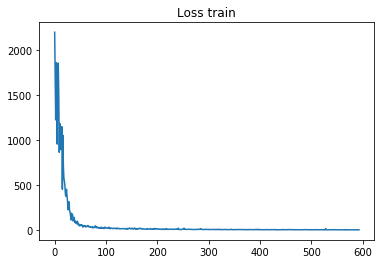

1 epoch: train loss 1.7585759
val loss: 2.4715526 test loss:  4.1210356


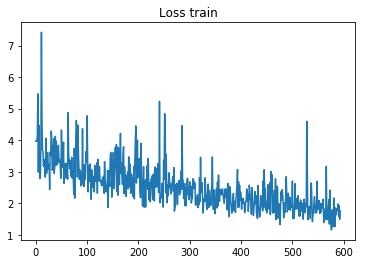

2 epoch: train loss 1.0692968
val loss: 1.4102565 test loss:  3.1127923


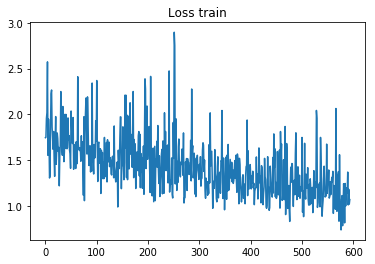

3 epoch: train loss 0.77297926
val loss: 0.9947073 test loss:  2.7186778


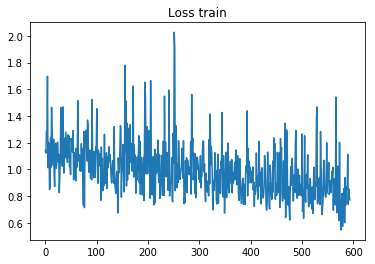

4 epoch: train loss 0.62787426
val loss: 0.7771389 test loss:  2.5168839


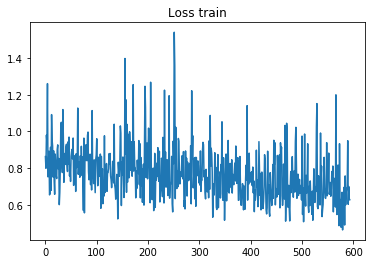

5 epoch: train loss 0.5454155
val loss: 0.6402912 test loss:  2.391129


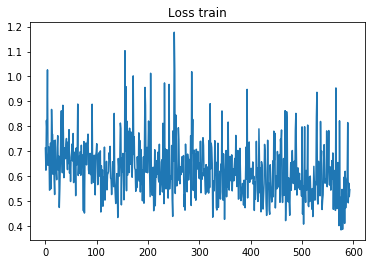

6 epoch: train loss 0.4460393
val loss: 0.5490171 test loss:  2.3101125


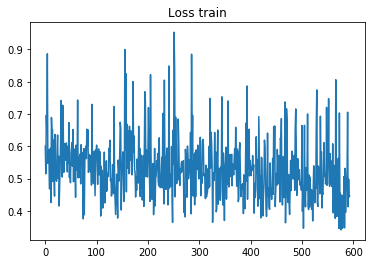

7 epoch: train loss 0.37432513
val loss: 0.48204693 test loss:  2.2511063


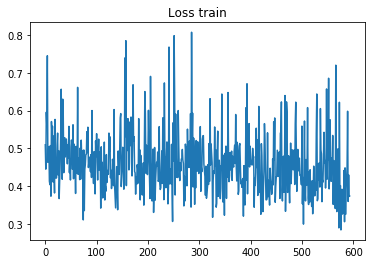

8 epoch: train loss 0.33951083
val loss: 0.43332887 test loss:  2.2085636


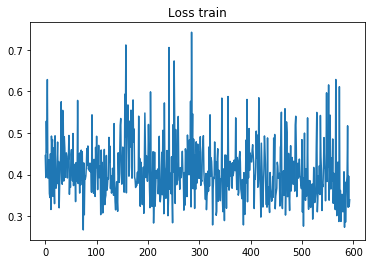

9 epoch: train loss 0.29996863
val loss: 0.3975977 test loss:  2.1798966


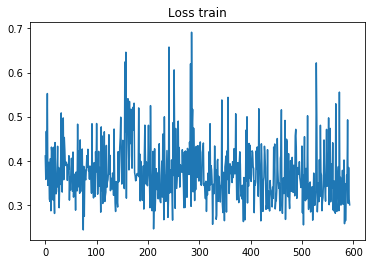

In [5]:
# training deep neural nets
set_seed(1)
sess = get_session()
state, action, out = model()
mean_loss = loss_function(out, action)
train_step = optimizer(mean_loss)
        
var= tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
sess.run(tf.global_variables_initializer())    



it_num = int(1e+5)
batch_size = 100
batch_size2 = 30
epoch = 10

for i in range(epoch):
    loss_his, loss_his2, loss_his3 = [], [], []
    for j in range(int(x_train.shape[0]/batch_size)):
        _, loss_train = sess.run([train_step, mean_loss], feed_dict={state:x_train[j*batch_size:(j+1)*batch_size]
                                                                                , action:y_train[j*batch_size:(j+1)*batch_size]})
        loss_his.append(loss_train)
        
        loss_val = sess.run([mean_loss], feed_dict={state:x_val[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_val[j*batch_size2:(j+1)*batch_size2]})
        loss_test = sess.run([mean_loss], feed_dict={state:x_test[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_test[j*batch_size2:(j+1)*batch_size2]})
        loss_his2.append(loss_val)
        loss_his3.append(loss_test)
        
    print(str(i)+' epoch: '+'train loss', loss_train)
    print('val loss: '+ str(np.mean(np.array(loss_his2)))+' test loss: ',str(np.mean(np.array(loss_his3))) )
    
    #plt.plot(loss_his)
    #plt.title('Loss train')
    #plt.show()

In [6]:
# evaluate policy
env = gym.make('Humanoid-v2')
num_rollouts = 10

for i in range(num_rollouts):
    returns = []
    observations = []
    actions = []
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        env.render()
    returns.append(totalr)

    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
Creating window glfw
returns [243.54398541743942]
mean return 243.54398541743942
std of return 0.0
iter 1
returns [273.81221462942125]
mean return 273.81221462942125
std of return 0.0
iter 2
returns [175.28302607200052]
mean return 175.28302607200052
std of return 0.0
iter 3
returns [312.34623848553855]
mean return 312.34623848553855
std of return 0.0
iter 4
returns [676.3060132179986]
mean return 676.3060132179986
std of return 0.0
iter 5
returns [396.7041260007451]
mean return 396.7041260007451
std of return 0.0
iter 6
returns [506.91438154294576]
mean return 506.91438154294576
std of return 0.0
iter 7
returns [208.87275164494918]
mean return 208.87275164494918
std of return 0.0
iter 8
returns [457.52339679719853]
mean return 457.52339679719853
std of return 0.0
iter 9
returns [325.